Imports

In [ ]:
# Import necessary libraries
from nnsight import LanguageModel
import torch

# Initialize the language model with specific parameters
model = LanguageModel("google/gemma-2b-it", trust_remote_code=True, device_map="auto", low_cpu_mem_usage=True, torch_dtype=torch.float16)
model.requires_grad_(False)

# Download the SAE weights file (commented out)
#!wget -c 'https://huggingface.co/jbloom/Gemma-2b-Residual-Stream-SAEs/resolve/main/gemma_2b_blocks.6.hook_resid_post_16384_anthropic_fast_lr/sae_weights.safetensors?download=true' -O 'sae.safetensors'

# Load the SAE weights using safetensors
from safetensors import safe_open
with safe_open("/home/ashater/work/sae.safetensors", framework="pt") as st:
    w_dec = st.get_tensor("W_dec")

import pandas as pd

Parameters

In [ ]:
#@title Self-explanation in 18 lines
feature = 471  #@param {type: "integer"}
#feature = 5892  #@param {type: "integer"}
#feature = 9415
scale = 67.5  #@param {type: "number"}
se_demo = True  #@param {type: "boolean"}
max_new_tokens = 80  #@param {type: "integer"}
n_generate = 1  #@param {type: "integer"}
vals = ['positive', 'neutral', 'negative']
samples = pd.read_excel('/home/ashater/work/sae/sentence_sentiment_gpt4o.xlsx')

Main code


In [ ]:
w_dec.shape

torch.Size([16384, 2048])

In [ ]:
#from dictionary_learning.dictionary import AutoEncoder
#ae = AutoEncoder.from_pretrained(w_dec)

v = samples[samples.Sentence.map(lambda x: ' rating ' in x)].index.tolist()


In [ ]:
full_res = []
#v = range(0,10)
for ismpl in v:
    # prompt = """<start_of_turn>user\nYou are financial analyst providing credit rating.
    # Can you provide rating for the following sentnece as a financial credit rating, expressed as grades
    # AAA:The highest rating, indicating an extremely strong ability to meet financial commitments,
    # AA:A very strong ability to meet financial commitments,
    # A:A strong ability to meet financial commitments, but more susceptible to adverse economic conditions,
    # BBB:An adequate ability to meet financial commitments, but more subject to adverse economic conditions
    # BB: Marginal financial security characteristics
    # B: Weak financial security characteristics
    # CC: A default is expected to be a virtual certainty
    # C: Highly vulnerable to nonpayment
    # D: In default or in breach of an imputed promise, provide one rating X
    # ?""" +  samples.iloc[ismpl].Sentence + '?' + """ <end_of_turn>\n<start_of_turn>model"""

    prompt = """<start_of_turn>user\nCan you rate  the following sentnece X as a financial credit sentiment, very positive,
    somewhat positive, neutral, somewhat negative,
    very negative? """ + samples.iloc[ismpl].Sentence + '<end_of_turn>\n<start_of_turn>model\nThe sentiment of the setence is "X"'
    #prompt = '<start_of_turn>user\nWhat is the meaning of the word "X"?<end_of_turn>\n<start_of_turn>model\nThe meaning of the word "X" is "'
    positions = [i for i, a in enumerate(model.tokenizer.encode(prompt)) if model.tokenizer.decode([a]) == "X"]
    with model.generate(prompt, max_new_tokens=max_new_tokens, num_return_sequences=n_generate, do_sample=False, temperature=0, top_k=1, scan=False, validate=False) as gen:
        vector = w_dec[[feature]]
        vector = vector / vector.norm()
        vector = vector * scale
        for position in positions:
           model.model.layers[2].output[0][:, position] = vector
        out = model.generator.output.save()
        resid = model.model.layers[6].output.save()

    features = sae.encode(resid[0])
    summed_activations = features.abs().sum(dim=1) # Sort by max activations
    top_activations_indices = summed_activations.topk(20).indices # Get indices of top 20
    res  = { v:0 for v in vals }
    for i, l in enumerate(model.tokenizer.batch_decode(out)):
        s = repr(l.partition(prompt)[2].partition("<eos>")[0])
        print(samples.iloc[ismpl].Sentence+"|"+ s + "|" + str(top_activations_indices))
        # print(str(top_activations_indices))
        for k in res.keys():
            if k in s:
                res[k]+=1
    full_res.append(res)

Its credit rating was slashed to junk status after missing key financial benchmarks.|' which is considered a somewhat negative financial credit sentiment.'|tensor([[  471,  3553, 11912,  3390, 15881, 10859, 13743,  5347,  1630, 16334,
           556,  5490, 11785,  1587,  5577,  2241,  5978,  1491, 15857, 13700]],
       device='cuda:0')
The business failed to meet debt repayment deadlines, leading to a credit rating downgrade.|' as a financial credit sentiment. It is somewhat negative as it indicates that the business failed to meet debt repayment deadlines, leading to a credit rating downgrade.'|tensor([[  471,  3553, 11912, 13743,  3390, 15881,  5347,  1630, 16334,   556,
          5490, 11785,  1587,  5577, 10859,  2241,  5978,  4675,  1491, 13700]],
       device='cuda:0')
A downgrade of the vehicle’s credit rating has raised its borrowing costs significantly.|" which is a somewhat negative sentiment. It indicates that the vehicle's credit rating has been downgraded, which will ma

In [ ]:
pd.Series(features[0].mean(axis=0).sort().indices.cpu()).to_clipboard()

In [ ]:
 #model.model.layers[6].mlp
# Choose a layer you want to focus on
# For this tutorial, we're going to use layer 2
from sae_lens import SAE
layer = 6

# get the SAE for this layer
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gemma-2b-res-jb",
    sae_id = f"blocks.{layer}.hook_resid_post",
    device = 'cuda:0'
)



In [ ]:
ww == sae.W_dec


tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [ ]:


features = sae.encode(resid[0])
summed_activations = features.abs().sum(dim=1) # Sort by max activations
top_activations_indices = summed_activations.topk(20).indices # Get indices of top 20
top_activations_indices

tensor([[11912, 15760, 10859,  3390, 15881, 13327,  5347, 16334,   556, 11785,
          7984,  5490,  5624, 11160, 12388, 15202,  6189,  1630,  5396,  6877]],
       device='cuda:1')

In [ ]:
features = sae.encode(mlp_12)
summed_activations = features.abs().sum(dim=1) # Sort by max activations
top_activations_indices = summed_activations.topk(20).indices # Get indices of top 20
top_activations_indices

tensor([[ 2372,  5882, 14656,  8709, 10520, 15952, 14399, 10740,  5578,  7286,
         11558,  9422,  4107,  8090,  5215, 16311,  6564, 10680,  3614,   981]],
       device='cuda:1')

In [ ]:
from tqdm import tqdm
#@title Self-explanation in 18 lines
feature = 471  #@param {type: "integer"}
scale = 57.0  #@param {type: "number"}

max_new_tokens = 40  #@param {type: "integer"}
n_generate = 1  #@param {type: "integer"}
vals = ['positive', 'neutral', 'negative']
full_res = []
for ismpl in tqdm(range(0, samples.shape[0])):
    prompt = """<start_of_turn>user\nCan you rate  the following sentnece as a financial credit sentiment, very positive,
    somewhat positive, neutral, somewhat negative,
    very negative? """ + samples.iloc[ismpl].Sentence + '<end_of_turn>\n<start_of_turn>model\nThe sentiment of the setence is "X"'

    positions = [i for i, a in enumerate(model.tokenizer.encode(prompt)) if model.tokenizer.decode([a]) == "X"]
    #print(prompt)

    with model.generate(prompt, max_new_tokens=max_new_tokens, num_return_sequences=n_generate, do_sample=False, temperature=0, top_k=1, scan=False, validate=False) as gen:
        # vector = w_dec[[feature]]
        # vector = vector / vector.norm()
        # vector = vector * scale
        # for position in positions:
        #     model.model.layers[2].output[0][:, position] = vector
        out = model.generator.output.save()
        resid = model.model.layers[6].output.save()

    # features = sae.encode(resid[0])
    # summed_activations = features.abs().sum(dim=1) # Sort by max activations
    # top_activations_indices = summed_activations.topk(20).indices # Get indices of top 20

    res  = { v:0 for v in vals }
    for i, l in enumerate(model.tokenizer.batch_decode(out)):
        s = repr(l.partition(prompt)[2].partition("<eos>")[0])

    full_res.append(s)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5924/5924 [2:20:53<00:00,  1.43s/it]


In [ ]:
#top_actv = top_actv.map(lambda x:x[0]) =  pd.DataFrame.from_records(full_res)[0].map(lambda x: x.tolist())
top_actv = pd.read_csv('/home/ashater/work/sae/sentiment_top20.csv', index_col=0).map(lambda x: eval(x))
top_actv = top_actv.map(lambda x:x[0])

In [ ]:
import re
def get_rating(st):
   # Define the regex pattern to match the specified words (case insensitive)
   pattern = r"\b(very positive|somewhat positive|positive|neutral|negative|somewhat negative|very negative)\b"

   # Find all matches in the test string (case insensitive)
   return re.findall(pattern, st, re.IGNORECASE)
samples['Fin Steer'] = pd.DataFrame.from_records(full_res)[1].tolist()
samples['Fin Steer Sentiment'] = samples['Fin Steer'].map(get_rating)
samples['Fin Steer Sentiment'] = samples['Fin Steer Sentiment'].map(lambda x: x[0] if len(x)>1 else x)
samples['Fin Steer Sentiment'] = samples['Fin Steer Sentiment'].map(lambda x: x[0] if type(x) == list and len(x) >0  else x)
samples['Fin Steer Sentiment'] = samples['Fin Steer Sentiment'].map(lambda x: 'N/A' if (type(x) == list and len(x) ==0) else x)


In [ ]:
vlack_neg = pd.read_clipboard()
vlack_neg.set_index('ind', inplace=True)

False

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
words = pd.read_csv('/mnt/c/temp/words.csv', index_col=0)
vp = samples[samples['Fin Steer Sentiment'].map(lambda x: x.lower()) == 'neutral'].index


dffd = pd.Series(np.array(top_actv.loc[vp]['0'].tolist()).reshape(vp.shape[0]*20))
top_activations = dffd.groupby(dffd.values).count()


#top_actv.loc[vp]['0']

In [ ]:
all_activations = top_activations[top_activations.sort_values() == vp.shape]
all_activations[all_activations.index.map(lambda x: x in vlack_neg.index)]

2241    866
dtype: int64

In [ ]:
w_lookup = words.map(lambda x: eval(x)[0])
top_words = pd.concat([w_lookup.loc[top_activations.index], top_activations], axis=1)
top_words.columns = ['words','top activations']

top_words.sort_values('top activations', ascending=False).to_clipboard()

In [ ]:
sum(samples.apply(lambda x: (x[2].lower() == x[5].lower()), axis=1))

#$samples['Fin Steer Sentiment'].map(lambda x: 'N/A' if (type(x) == list and len(x) ==0) else x)

/tmp/ipykernel_3664/4048761803.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(samples.apply(lambda x: (x[2].lower() == x[5].lower()), axis=1))


2189

In [ ]:
samples2 = pd.read_excel('/mnt/c/Temp/all_steer.xlsx')

In [ ]:
samples2['Credit Rating Steer SAE 471'] = samples['Fin Steer']
samples2['Credit Rating  SAE 471 Steer Sentiment'] = samples['Fin Steer Sentiment']

KeyError: 'Fin Steer'

In [ ]:
#samples2.to_excel('/mnt/c/Temp/all_steer_57_all.xlsx')
samples2['No steer sentiment'] = samples2['No steer sentiment'].map(lambda x: eval(x))
samples2['No steer sentiment'] = samples2['No steer sentiment'].map(lambda x: x[0] if len(x)>1 else x)
samples2['No steer sentiment'] = samples2['No steer sentiment'].map(lambda x: x[0] if type(x) == list and len(x) >0  else x)
samples2['No steer sentiment'] = samples2['No steer sentiment'].map(lambda x: 'N/A' if (type(x) == list and len(x) ==0) else x)

In [ ]:
#samples2.iloc[0]
samples2[samples2.apply(lambda x: (x[3].lower() == x[6].lower() != x[8].lower()), axis=1)].to_clipboard()

/tmp/ipykernel_3664/2702379773.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  samples2[samples2.apply(lambda x: (x[3].lower() == x[6].lower() != x[8].lower()), axis=1)].to_clipboard()


In [ ]:
 from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
lables = ['very positive', 'positive','somewhat positive', 'neutral','somewhat negative', 'negative', 'very negative', 'n/a' ]

v = samples2.Sentence.map(lambda x: ' rating ' in x)
gt = samples2.apply(lambda x: x[3].lower(), axis=1)
pred1 = samples2.apply(lambda x: x[6].lower(), axis=1)
pred2 = samples2.apply(lambda x: x[8].lower(), axis=1)

cfd1 = ConfusionMatrixDisplay(confusion_matrix(gt, pred, labels=lables), display_labels=lables)
cfd2 = ConfusionMatrixDisplay(confusion_matrix(gt, pred2, labels=lables), display_labels=lables)


NameError: name 'samples2' is not defined

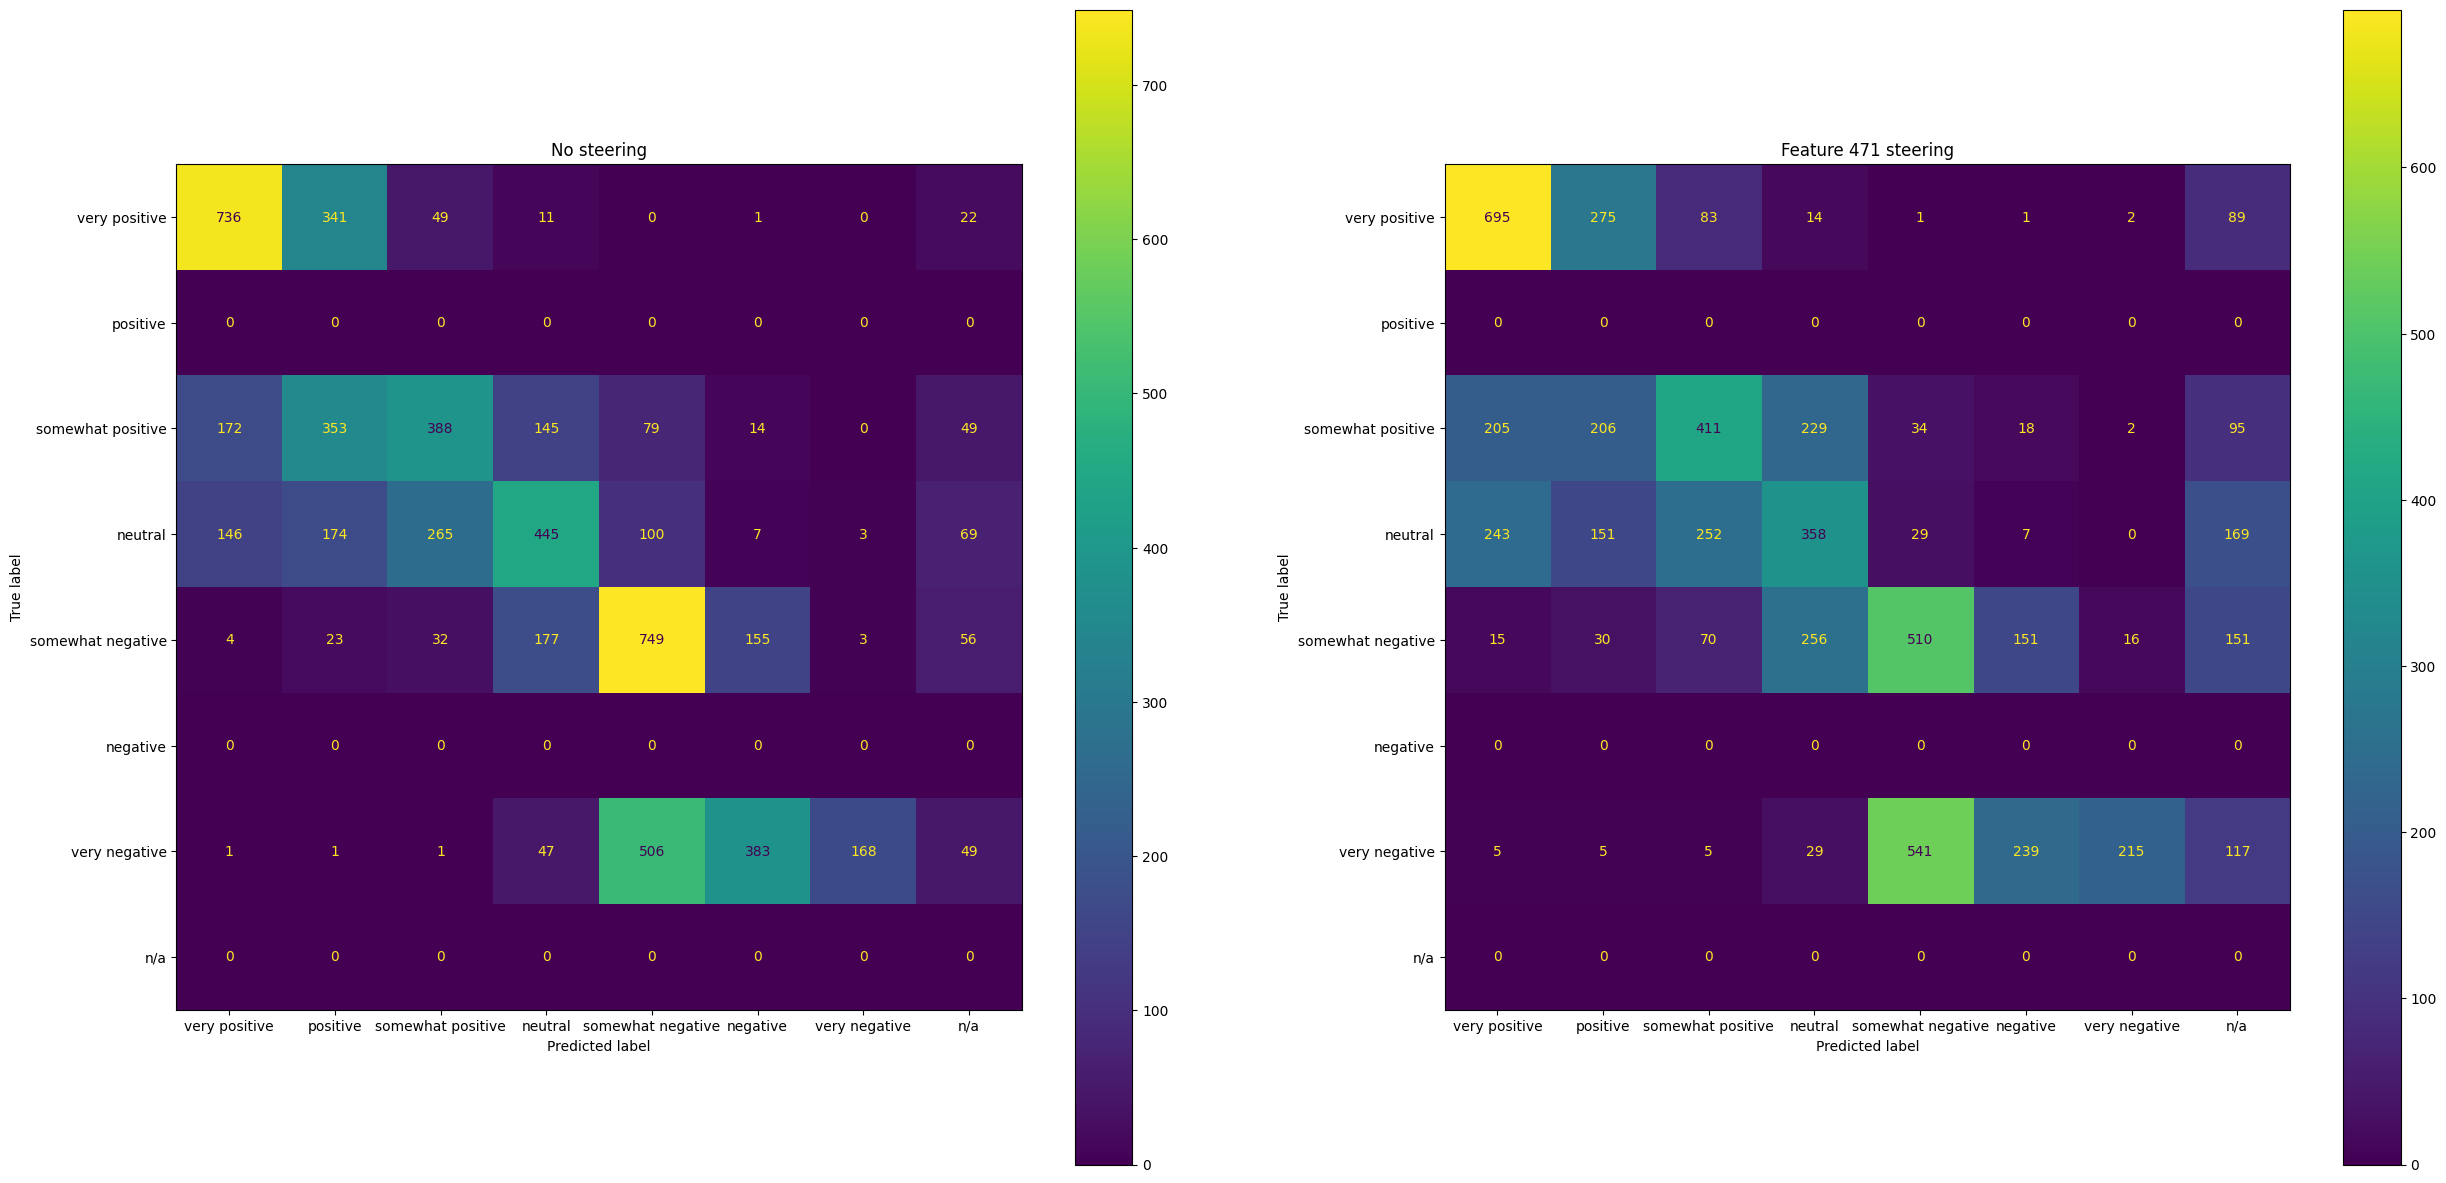

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 15))
axes[0].set_title('No steering')
axes[1].set_title('Feature 471 steering')
cfd1.plot(ax=axes[0])
cfd2.plot(ax=axes[1])
#fig.tight_layout()

In [ ]:
pred.unique()

array(['very positive', 'positive', 'negative', 'very negative', 'n/a',
       'somewhat negative', 'neutral', 'somewhat positive'], dtype=object)